In [1]:
import fastf1
import fastf1.plotting
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

### Pre Defined

In [ ]:
compound_color = {'HARD': '#f0f0ec', 
                  'INTERMEDIATE': '#43b02a', 
                  'MEDIUM': '#ffd12e', 
                  'SOFT': '#da291c', 
                  'TEST-UNKNOWN': '#434649', 
                  'UNKNOWN': '#00ffff', 
                  'WET': '#0067ad'}

In [ ]:
race = fastf1.get_session(2023,9,'R')
race.load()


core           INFO 	Loading data for Austrian Grand Prix - Race [v2.3.1]
api            INFO 	Fetching driver list...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api         WARNING 	Driver 20: Encountered 1 timing integrity error(s) near lap(s): [34].
This might be a bug and should be reported.
api            INFO 	Fetching timing app data...
core           INFO 	Processing timing data...
api            INFO 	Fetching session status data...
api            INFO 	Fetching track status data...
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in row.iteritems():
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in row.iteritems():

In [3]:
laps = race.laps
drivers = race.drivers[:10]
all_laps = laps
all_laps['LapStartTimeS'] = all_laps["LapStartTime"].dt.total_seconds()
all_laps['DeltaTime'] = 0

In [4]:
delta_time = all_laps[["DriverNumber","Driver","LapNumber","LapStartTime","LapStartTimeS","DeltaTime"]]
for i in drivers:
    a = delta_time.loc[delta_time["DriverNumber"] == i,["LapStartTimeS"]].reset_index() - delta_time.loc[delta_time["DriverNumber"] == '1',["LapStartTimeS"]].reset_index()
    length = len(delta_time.loc[delta_time["DriverNumber"] == i, "DeltaTime"])
    delta_time.loc[delta_time["DriverNumber"] == i, "DeltaTime"] = a.loc[:, "LapStartTimeS"].values[:length]

### Gap to race winner graph

NameError: name 'race_len' is not defined

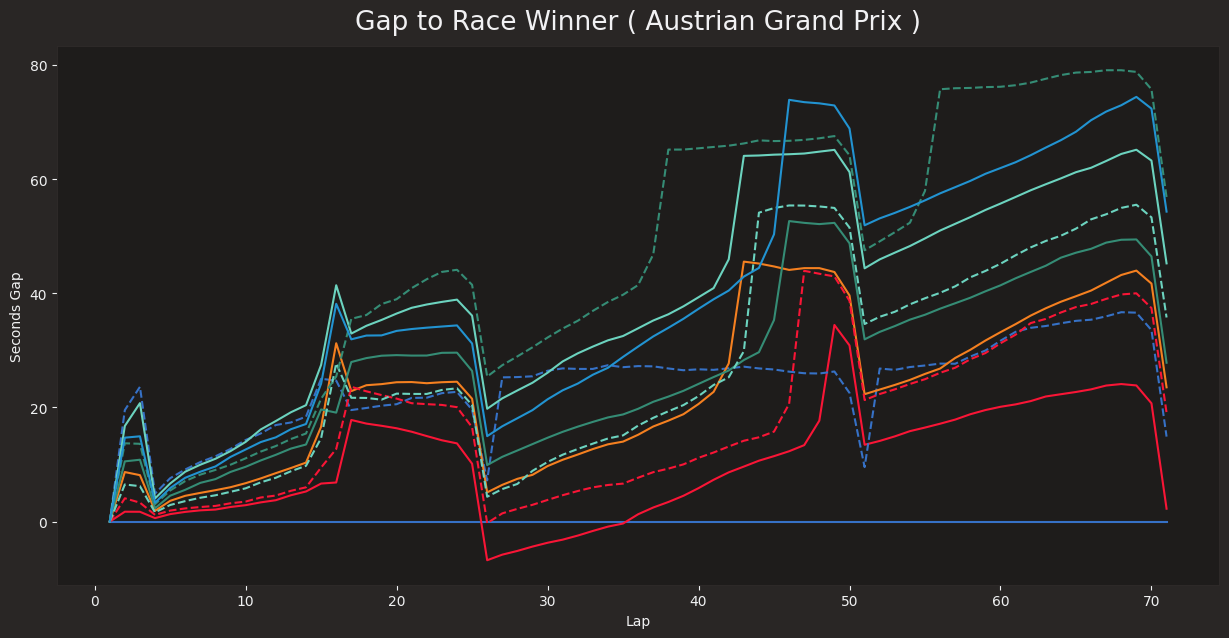

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
color_picked = []
max_gap = int(delta_time["DeltaTime"].max())
for i in drivers:
    x = delta_time.loc[delta_time["DriverNumber"]==i,["LapNumber"]]
    y = delta_time.loc[delta_time["DriverNumber"]==i,["DeltaTime"]]
    
    driver_name = race.get_driver(i)["Abbreviation"]
    team_color = race.get_driver(i)["TeamColor"]
    
    if team_color in color_picked:
        plt.plot(x, y, color="#"+team_color, linestyle='dashed', label=driver_name)
    else:    
        plt.plot(x, y, color="#"+team_color, linestyle='solid', label=driver_name)
        color_picked.append(team_color)

# Customize the plot
plt.title('Gap to Race Winner ( '+race.event["EventName"]+' )')
plt.xlabel('Lap')
plt.ylabel('Seconds Gap')
plt.xticks(range(0, race_len, axes(race_len)))
plt.yticks(range(0, max_gap, 10))
plt.gca().invert_yaxis()

# Add legend
plt.legend()

# Display the plot
plt.show()
